<a href="https://colab.research.google.com/github/JADukeAIPI/AIPIProject/blob/main/Copy_of_LuxuryCarAPIMultipleDates.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

AIPI 510 PROJECT

This will allow for generating a dataframe of 'luxury' cars for several dates (currently set up to start from today and checks for 24 hour bookings for each day for next x days). The groupby at the end shows the number of vehicles available for each day, which could indirectly give us how many reservations if we assume the cars are picked up and returned in atlanta and the fleet inventory is stable.

In [2]:
from bs4 import BeautifulSoup
import pandas as pd
import numpy as np
import requests
import matplotlib.pyplot as plt
import requests
import datetime
from datetime import datetime, timedelta
from sklearn.linear_model import LinearRegression
import statsmodels.api as sm
from sklearn.metrics import r2_score,mean_squared_error



In [3]:
today_date = datetime.today().strftime('%Y-%m-%d')

def get_date(number_days_from_today):

  end_date = datetime.today() + timedelta(days=number_days_from_today)
  end_date=end_date.strftime('%Y-%m-%d')
  return end_date



Getting Booking.com Rental Car API:


In [4]:
def get_booking_data(start_date, end_date):
	url = "https://booking-com.p.rapidapi.com/v1/car-rental/search"
	querystring = {"drop_off_longitude":"-84.419853","currency":"USD","sort_by":"recommended","drop_off_datetime":end_date + ' 12:00:00',"drop_off_latitude":"33.640411","from_country":"it","pick_up_longitude":"-84.419853","locale":"en-gb","pick_up_datetime":start_date + " 12:00:00","pick_up_latitude":"33.640411"}

	headers = {
		"X-RapidAPI-Key": "8bbb18c5b5mshcb2649ca8814f86p1d30a3jsn5a338ac42c22",
		"X-RapidAPI-Host": "booking-com.p.rapidapi.com"}

	response = requests.request("GET", url, headers=headers, params=querystring)
	results = response.json()
	df = pd.json_normalize(results, record_path =['search_results'])

	return df


In [5]:
def clean_api_df(data_df):
  df_cleaned = data_df.copy()
  
  #filter to the columns we want to keep
  columns_to_keep = ['vehicle_info.v_id', 'vehicle_info.v_name', 'vehicle_info.group', 'vehicle_info.transmission', 'route_info.dropoff.city', 'pricing_info.base_price', 'pricing_info.price', 'route_info.pickup.city']
  #filter to the types of vehicles in vehicle.group
  vehicle_groups_to_keep = ['Luxury']
  df_cleaned=df_cleaned[columns_to_keep]
  df_cleaned=df_cleaned[df_cleaned['vehicle_info.group'].isin(vehicle_groups_to_keep)]
  df_cleaned.rename(columns={'vehicle_info.v_id':'Vehicle_id', 'vehicle_info.v_name': 'Vehicle Name', 'vehicle_info.group': 'Category', 'pricing_info.base_price': 'Base Price', 'pricing_info.price': 'Price', 'vehicle_info.transmission': 'Transmission', 'route_info.dropoff.city': 'Dropoff City', 'route_info.pickup.city': 'Pickup City'}, inplace=True)
  df_cleaned.sort_values(by='Base Price', ascending=False, inplace=True)
  return df_cleaned

In [ ]:
#data_trial = get_booking_data('2022-11-20', '2022-11-21')
#clean_api_df(get_booking_data('2022-11-30', '2022-12-01'))


In [6]:
def get_bookings_multiple_dates(days=30):
  dfs = []
  for day in range(days):
    date_tuple = (get_date(day), get_date(day+1))
    #print(date_tuple)
    df_partial = clean_api_df(get_booking_data(*date_tuple))
    df_partial['Date Pickup']=date_tuple[0]
    df_partial['Date Dropoff'] = date_tuple[1]
    dfs.append(df_partial)

  df = pd.concat([dfs[i] for i in range(len(dfs))], axis=0) 

  return df



In [7]:
df_next_40_days = get_bookings_multiple_dates(40)
df_next_40_days

,Vehicle_id,Vehicle Name,Category,Transmission,Dropoff City,Base Price,Price,Pickup City,Date Pickup,Date Dropoff
181,644881573,Cadillac XTS,Luxury,Automatic,,146.40,151.77,,2022-11-16,2022-11-17
190,636479888,Cadillac XTS,Luxury,Automatic,,139.50,144.61,,2022-11-16,2022-11-17
189,646119413,Cadillac XTS,Luxury,Automatic,,133.53,138.42,,2022-11-16,2022-11-17
179,644901168,Cadillac XTS,Luxury,Automatic,,128.33,133.03,,2022-11-16,2022-11-17
198,636492688,Cadillac XTS,Luxury,Automatic,,121.58,126.04,,2022-11-16,2022-11-17
...,...,...,...,...,...,...,...,...,...,...
31,644841863,Cadillac XTS,Luxury,Automatic,,124.04,128.59,,2022-12-25,2022-12-26
32,735898091,Cadillac XTS,Luxury,Automatic,,123.27,127.79,,2022-12-25,2022-12-26
44,646141193,Cadillac XTS,Luxury,Automatic,,123.27,127.79,,2022-12-25,2022-12-26
26,636464758,Cadillac XTS,Luxury,Automatic,,117.50,121.81,,2022-12-25,2022-12-26


It seems like they usually have 26 such vehicles on hand, so can subtract from 26 to see how many are already reserved for each day


In [8]:
df_next_40_days['cars_available'] = df_next_40_days.groupby('Date Pickup')['Vehicle Name'].transform('count')

df_next_40_days["Reservation"] = df_next_40_days["cars_available"].apply(lambda x: 26 - x)
df_demand = df_next_40_days[['Date Pickup','Reservation']]
df_demand['Date Pickup'] = pd.to_datetime(df_demand['Date Pickup'])
df_demand_clean = df_demand.drop_duplicates()

df_demand_clean = df_demand_clean.set_index('Date Pickup')
df_demand_clean

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  """


,Reservation
Date Pickup,
2022-11-16,13
2022-11-17,13
2022-11-18,11
2022-11-19,11
2022-11-20,11
2022-11-21,0
2022-11-22,11
2022-11-23,24
2022-11-24,24


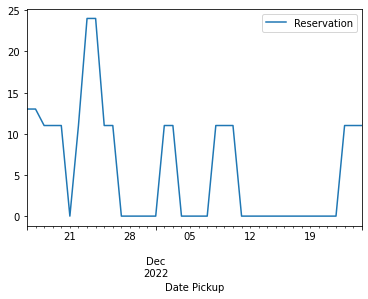

In [9]:
df_demand_clean.plot()

In [ ]:
df_next_40_days['car'] = df_next_40_days 

In [ ]:
#checking to see if the same car has different prices depending on the date

cars_prices = df_next_40_days.groupby(['Vehicle_id', 'Date Pickup'])['Price'].mean()
cars_prices
#maybe we can take Vehicle_id as input and plot x axis with Date Pickup y axis with Price